# Running Multi domain task problem solver 
***

> Pre work : moving the files to local

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/15122022_session/DF_Dpo.final.1005.tsv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Dpo_domains.0805.final.ultimate.tsv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Dpo.0805.embeddings.ultimate.csv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/prophage_similarity/phageboost/fastANI_20102022_out/clusters_99_80.extra_clean.2004.v2.tsv \
/media/concha-eloko/Linux/PPT_clean
    

> The Dpo prediction model in case predictions

In [2]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import pandas as pd
import os 
from collections import Counter
from Bio import SeqIO
import torch
import matplotlib.pyplot as plt
import numpy as np

path_work = "/media/concha-eloko/Linux/depolymerase_building"
model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase/checkpoint-198/"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

/home/concha-eloko/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /media/concha-eloko/Linux/depolymerase_building/esm2_t12_35M_UR50D-finetuned-depolymerase/checkpoint-198/ were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.weight', 'esm.contact_head.regression.bias']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

In [3]:
path_protein = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023"
from Bio import SeqIO

def model_out(sequence) :
    input_ids = tokenizer.encode(sequence, return_tensors='pt', truncation= True)
    outputs = model(input_ids)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = model.config.id2label
    tokens = []
    for token_id, token_probs in zip(input_ids[0], probs[0]):
        top_label_id = token_probs.argmax().item()
        tokens.append(int(labels[top_label_id].split("_")[1]))
    return tokens

def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        else:
            color = 'red'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()


def make_prediction(protein,database = "ppt") :
    dico_file = {"ppt" : "sword2_DepoSeq_pt2", "minibatch" : "sword2_Minibatch_pt2"}
    path_seq = f"{path_protein}/{dico_file[database]}/{protein}/{protein}_A/SWORD/{protein}_A/{protein}_A.fasta"
    seq = str(list(SeqIO.parse(path_seq, "fasta"))[0].seq)
    tokens = model_out(seq)
    plot_token(tokens)
    
    
def quickie_make_prediction(seq) :
    tokens = model_out(seq)
    plot_token(tokens)

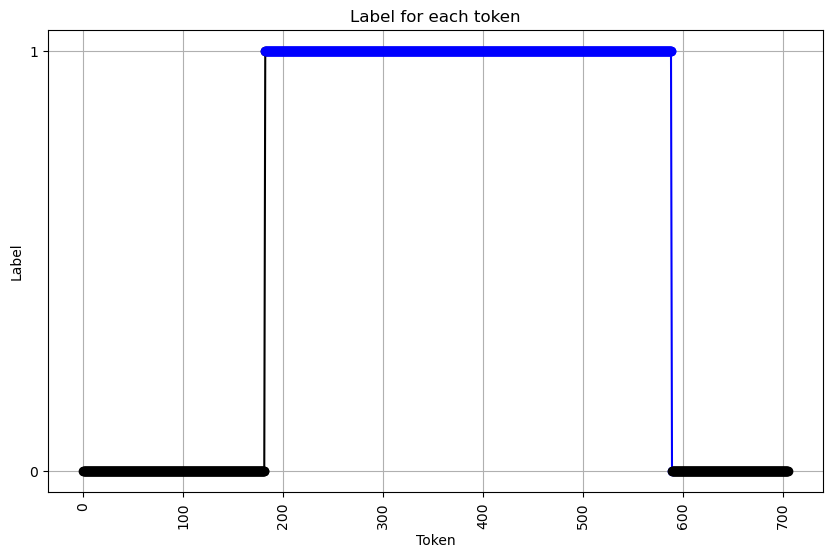

In [238]:
make_prediction("5377" , database = "ppt")

In [239]:
report['KL28']

{'precision': 0.35714285714285715,
 'recall': 0.35714285714285715,
 'f1-score': 0.35714285714285715,
 'support': 14}

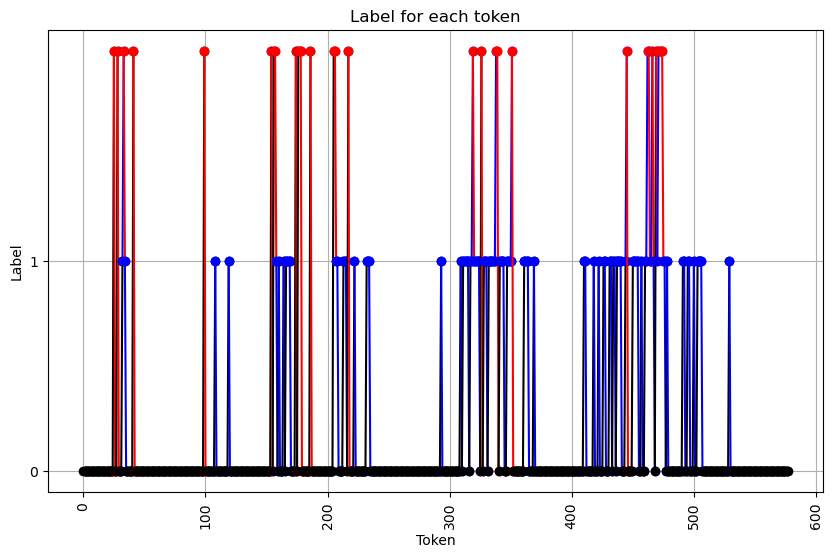

In [271]:
quickie_make_prediction("VNNMDQELEQESVFLFHAPCENCGSSDGNSVYSDGHEWCFVCEHRVPASEEREKKLSSRRPTGGKRVSNYDNSPLVFGEVNGRYSDLTARGISKATCQKAGYWIAKVRNELFQVADYRDQNGSIVSQKLRDKHKEFSTRGSHKSDALFGKHLWSGGKKIVITEGEIDMLTVMELQDCKYPVVSLGHGAKAAKKTCAANYEYLDQFDQIILMFDMDEAGRAAVEEAAQVLPPGKVFVAVLPMKDANECHLNGQSRAIMEQIWNANPWVPDGVVSAISLKDRVKEAMCSEASIGYLFSGCPGLNDRTLGMRGGEVIMVTSGSGMGKSTFVRQQALGLVRDQGLKVGMAMLEESVEETMEDLTGIANGVRLRQQPREFKQQLIESGKFDEWFDALFGSDKIHLYDSFAEAEVDRLLAKLHYMRTGLGCDVIILDHISIVVSASEESDERKMIDRLMTKLKGFAKSTGVVLIVICHLKNPEKGKAHEEGRPVSITDLRGSGSLRQLSDTIIALERNQQGDNPNLVLLRILKCRFNGIGVGIAGYMEYNGTTGLLEPSVYTGEEGEGDSSWAGHEEGDGDY")

***


### 1. Importing the modules 

> Local 

In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import scipy as sp
import subprocess
from scipy.spatial import distance
from tqdm import tqdm
from collections import Counter
import math
import datetime as dt
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez, pairwise2
from sklearn.decomposition import PCA

/home/concha-eloko/.local/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


> Remote

In [ ]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import subprocess
from scipy.spatial import distance
from tqdm import tqdm
from collections import Counter
import math
import datetime as dt
from Bio import SeqIO, Entrez, pairwise2
from sklearn.decomposition import PCA

***
### 2. Loading the Dataframes 

> Local

In [84]:
#import torch
import os 
import pandas as pd
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

# local :
path_project = "/media/concha-eloko/Linux/PPT_clean"
path_similarity = path_project

esm2_depo = pd.read_csv(f"{path_project}/Dpo.0805.embeddings.ultimate.csv" , header = None, sep = "," , index_col = 0)
df_info = pd.read_csv(f"{path_project}/DF_Dpo.final.1005.tsv" , sep = "\t", header =0)
family_df = pd.read_csv(f"{path_similarity}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)
dpo_final_info = pd.read_csv(f"{path_project}/Dpo_domains.0805.final.ultimate.tsv" , sep = "\t", names = ["0","Dpo","Fold","Prob","Domain_Boundaries","aa_domain","aa_full"])
dpo_final_info = dpo_final_info.drop(["0"] , axis = 1)


In [268]:
dpo_final_info

,Dpo,Fold,Prob,Domain_Boundaries,aa_domain,aa_full
0,ppt__6942,right-handed beta-helix,1.0,6942_A_1_1_466,MVDIYVDALGDFKNMQDGCTEAILKAVAHWGGRTDSAYVQGQKKYG...,MVDIYVDALGDFKNMQDGCTEAILKAVAHWGGRTDSAYVQGQKKYG...
1,ppt__898,right-handed beta-helix,0.795,898_A_5_201_576,DRSIYVNVNWFGADPSGAGWSSDAIYSAFQISNCVEFDGLYKYKGR...,MRFFSRRSIIKGFMPLPFFMFATSSHAERSRTNESPPTVAFNYEKD...
2,ppt__4863,right-handed beta-helix,1.0,4863_A_2_110_517,DFTLEDFGAISNPDVDSTAFIQAAFNSGLKLTSKTDGKYLLKDTIF...,MDFNKRNLIKAFMYTCASLPLTKVYSKPSIPRNEYFFPVDKLIYKA...
3,ppt__5053,right-handed beta-helix,1.0,5053_A_5_252_584,RRYFKVTDYPGGMPNSQVVRNSDGTLTIIKGANNTNAIKSAIADAQ...,MTVSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTLDTSESIVT...
4,ppt__499,right-handed beta-helix,1.0,499_A_4_170_653,REFYADAFPGIDPTGQTSSTQGILDAIAQINSQVDSTFNGDITTYP...,MAEVPLPTPTQALVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGV...
...,...,...,...,...,...,...
1994,minibatch__248,right-handed beta-helix,1.0,248_A_2_533_928,YPNEYWLQDFSGTTDIEWIQNAMDWVHDAGGGWLILSSDYVKKQFL...,MSNLPEQTAWESGIHQLEEEDRAKAGPGGVLNIQATQLANRTRWLR...
1995,minibatch__1414,right-handed beta-helix,1.0,1414_A_6_224_698,REFYADAFPGIDPTGQTSSTQGILDAIAQINSQVDSTFNGDITTYP...,MAITDTQQSAQFAASAAVSAAEAKQYALSIEKPIIDIAESVSEAKD...
1996,minibatch__1805,right-handed beta-helix,1.0,1805_A_1_1_460,MGDALLAVKQPYTGSVARTQHEKNWDSLNLLDFVYATDVVDGFVDY...,MGDALLAVKQPYTGSVARTQHEKNWDSLNLLDFVYATDVVDGFVDY...
1997,minibatch__985,right-handed beta-helix,1.0,985_A_2_91_554,TDLINYLALNGASERTVLSRLRDNIYITDFYSENDGDDWHPAYQRA...,MYHLDNTSGVPEMPEPKETQTISTRWFGESVDQGGISWPGADWFNI...


> Remote

In [ ]:
import os 
import pandas as pd
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')
# Remote :
path_project = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_similarity = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/prophage_similarity/phageboost/fastANI_20102022_out"

esm2_depo = pd.read_csv(f"{path_project}/Dpo.0805.embeddings.ultimate.csv" , header = None, sep = "," , index_col = 0)
df_info = pd.read_csv(f"{path_project}/DF_Dpo.final.1005.tsv" , sep = "\t", header =0)
family_df = pd.read_csv(f"{path_similarity}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)
dpo_final_info = pd.read_csv(f"{path_project}/Dpo_domains.0805.final.ultimate.tsv" , sep = "\t", names = ["0","Dpo","Fold","Prob","Domain_Boundaries","aa_domain","aa_full"])
dpo_final_info = dpo_final_info.drop(["0"] , axis = 1)

***
## Make the working DataFrame 

In [16]:
df_dpo_info = df_info[df_info["index"].isin(esm2_depo.index)]
df_dpo_info_ultimate = df_dpo_info.drop_duplicates(subset = ["Infected_ancestor","index"], keep = "first")

df_dpo_info_ultimate

,Phage,KL_type_LCA,Infected_ancestor,Protein_name,Dataset,index,seq
1,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__142,ppt,ppt__1,MSVPNQTPYNIYTANGLTTVFTYEFYIISASDLRVSINGDVVTSGY...
4,GCF_016651625.1__phage12,KL43,GCF_016651625.1,GCF_016651625.1__phage12__59,ppt,ppt__4,MSISKRNFLKAVSCAYFFYSFKALTKVNQPIEDYISTKDKNTWPSK...
23,GCF_902156295.1__phage7,KL107,n29132913,GCF_902156295.1__phage7__1791,ppt,ppt__21,MAFVTTQDGVNIYFKDWGPKEAQPIVFHHGWPLSADDWDNQMLFFL...
24,GCF_902156295.1__phage5,KL107,n29132913,GCF_902156295.1__phage5__1408,ppt,ppt__22,MTVSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVT...
29,GCF_000281355.1__phage7,KL107,81.9/1003170,GCF_000281355.1__phage7__19,ppt,ppt__21,MAFVTTQDGVNIYFKDWGPKEAQPIVFHHGWPLSADDWDNQMLFFL...
...,...,...,...,...,...,...,...
50948,GCF_021229915.1__phage2,KL28|KL123|KL10|KL60,35.1/97,GCF_021229915.1__phage2__1759,minibatch,minibatch__2185,MGQCSDLTALRTIEPTASNQRISVASYSPGWAGLIGAPVGGGEFYY...
50950,GCF_900503545.1__phage15,KL17,n4896,GCF_900503545.1__phage15__0,minibatch,minibatch__2187,GVDIILPFSGKFASKSLYLHYDPIKNPDWIGRPGRLTIRGSVLGHA...
50953,GCF_017310465.1__phage2,KL74,78.2/1005632,GCF_017310465.1__phage2__1759,minibatch,minibatch__2190,MTVSTEVDHNDYTGNGVTTSFPYTFRIFKKSDLTVQVADLNENITV...
50955,GCF_021228755.1__phage12,KL43,GCF_021228755.1,GCF_021228755.1__phage12__2003,minibatch,minibatch__2192,MSFYLTGNPVPSASMPDVHDNAQNLDFALNEITSTFWTDRLGRRRM...


> Generate the DF

In [98]:
# Write the two DF 
with open(f"{path_project}/MethodB_1.1705.csv", "w") as outfile :
    with open(f"{path_project}/MethodB_1.1705.ambiguous.csv", "w") as outfile_amb :
        for _,row in df_dpo_info_ultimate.iterrows() :
            index = row["index"]
            prophage_id = family_df[family_df["prophage"] == f"{row['Phage']}.fasta"]["prophage_id"].values[0]
            embeddings = ",".join(map(str, esm2_depo.loc[row["index"]].values.tolist()))
            KL_type = row["KL_type_LCA"]
            big_vector = f"{prophage_id},{embeddings}"
            if KL_type.count("|") == 0 :
                big_vector = f"{index},{prophage_id},{embeddings},{KL_type}\n"
                outfile.write(big_vector)
            else :
                big_vector = f"{index},{prophage_id},{embeddings}\n"
                outfile_amb.write(big_vector)


***
# Fit the model 

In [99]:
df_model = pd.read_csv(f"{path_project}/MethodB_1.1705.csv", sep = ",", header = None)
df_ambig = pd.read_csv(f"{path_project}/MethodB_1.1705.ambiguous.csv", sep = ",", header = None)

In [101]:
df_model

,1,2,3,4,5,6,7,8,9,10,...,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282
0,prophage_12186,-0.018416,0.022387,0.002399,-0.017278,-0.087826,0.021351,0.027942,-0.098224,0.030447,...,0.004437,0.087907,0.015800,0.025778,0.065790,0.034045,-0.070899,0.016068,0.065339,KL43
1,prophage_924,0.026004,0.024372,-0.000237,0.007180,-0.097511,0.028741,0.002062,-0.077674,-0.000671,...,-0.026018,0.018206,0.036751,-0.032549,0.064112,0.061520,-0.024423,-0.027998,0.028089,KL43
2,prophage_15,0.035789,0.004226,-0.022608,0.016881,-0.025078,-0.014850,0.038868,-0.106283,0.037216,...,-0.078897,-0.061039,0.000776,-0.054214,0.027240,0.044547,-0.133716,-0.016950,0.110996,KL107
3,prophage_5,-0.001908,0.069393,-0.018716,0.004960,-0.079390,0.035098,0.018252,-0.114789,0.060250,...,0.009750,0.085488,0.022026,0.008495,0.067882,0.053004,-0.082986,0.057684,0.034789,KL107
4,prophage_15,0.035789,0.004226,-0.022608,0.016881,-0.025078,-0.014850,0.038868,-0.106283,0.037216,...,-0.078897,-0.061039,0.000776,-0.054214,0.027240,0.044547,-0.133716,-0.016950,0.110996,KL107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,prophage_195,0.028878,0.060873,0.014102,-0.003680,-0.080260,0.007755,0.006217,-0.034849,0.075132,...,-0.002817,0.089326,0.009605,0.024522,0.003727,0.038779,-0.089558,0.057090,0.067429,KL28
4562,prophage_328,-0.009378,0.047410,-0.000560,-0.083427,-0.047251,0.007595,0.010811,-0.056390,0.089132,...,0.030203,0.062313,-0.025842,0.013362,0.067620,-0.000699,-0.118188,0.043839,0.087391,KL17
4563,prophage_121,0.008646,0.044795,-0.014744,0.002807,-0.074263,0.033088,0.039145,-0.089562,0.075162,...,0.009240,0.135452,0.025833,0.033759,0.034152,0.073932,-0.077119,0.069238,0.050791,KL74
4564,prophage_5956,-0.015836,0.026584,0.000171,-0.015946,-0.100962,0.037870,0.028782,-0.105174,0.050838,...,-0.006725,0.079048,0.013871,0.027114,0.073868,0.016247,-0.065178,0.028373,0.065663,KL43


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

df_model = pd.read_csv(f"{path_project}/MethodB_1.1705.csv", sep = ",", header = None)
Dpo_indices = df_model[0]
df_model = df_model.drop([0], axis =1)
df_model[1] = LabelEncoder().fit_transform(df_model[1])

# Prepare the input data
X = df_model.drop(1282, axis=1)
y = df_model[1282]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Test the data
y_pred = rf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         KL1       0.29      0.29      0.29         7
        KL10       0.50      0.35      0.41        17
       KL102       0.43      0.33      0.38         9
       KL105       0.83      1.00      0.91         5
       KL106       0.87      0.54      0.67        48
       KL107       0.76      0.91      0.83       101
       KL108       1.00      1.00      1.00         1
       KL109       0.00      0.00      0.00         1
        KL11       0.00      0.00      0.00         1
       KL110       0.20      0.25      0.22         4
       KL111       0.50      0.58      0.54        12
       KL112       0.67      0.80      0.73         5
       KL113       1.00      1.00      1.00         1
       KL114       0.40      0.67      0.50         3
       KL116       1.00      1.00      1.00         1
       KL117       1.00      1.00      1.00         1
       KL118       0.67      1.00      0.80         2
        KL12       0.75    

/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

df_model[0] = LabelEncoder().fit_transform(df_model[0])

# Prepare the input data
X = df_model.drop(1281, axis=1)
y = df_model[1281]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(space):
    model = RandomForestClassifier(n_estimators = int(space['n_estimators']), 
                                   max_depth = int(space['max_depth']), 
                                   min_samples_leaf = int(space['min_samples_leaf']), 
                                   random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK }

# Define the search space for the hyperparameters
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 1),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

trials = Trials()

# Run the hyperparameter search using the TPE algorithm
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)
# Best:  {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 495.0}

100%|█████████████████████████████████████| 50/50 [33:33<00:00, 40.28s/trial, best loss: -0.7439824945295405]
Best:  {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 495.0}


The best parameters for the RF : <br> Best:  {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 495.0}

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


df_model = pd.read_csv(f"{path_project}/MethodB_1.1705.csv", sep = ",", header = None)
Dpo_indices = df_model[0]
df_model = df_model.drop([0], axis =1)
df_model[1] = LabelEncoder().fit_transform(df_model[1])

# Prepare the input data
X = df_model.drop(1282, axis=1)
y = df_model[1282]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best = {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 495.0}
best_model = RandomForestClassifier(n_estimators=int(best['n_estimators']), 
                                    max_depth=int(best['max_depth']), 
                                    min_samples_leaf=int(best['min_samples_leaf']), 
                                    random_state=42)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)
class_labels = best_model.classes_

# Print the classification report
report = classification_report(y_test, y_pred_best, output_dict=True)


In [104]:
report = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report)
report_df = report_df.T
report_df = report_df.round(2)
report_df.to_csv(f"{path_project}/RF_optimized.report.tsv",sep = "\t", header = True, index = True)

In [233]:
report['KL25']

{'precision': 0.7857142857142857,
 'recall': 0.9166666666666666,
 'f1-score': 0.8461538461538461,
 'support': 36}

> Get the predictable KL_types :

In [187]:
KL_types_clean = [ktype for ktype in report if ktype[0] == "K" if report[ktype]["f1-score"] > 0.5]


***

> Using a Neural Network :

In [45]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score , classification_report
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Format the Data :
le = LabelEncoder()
df_model[0] = LabelEncoder().fit_transform(df_model[0])
X = df_model.drop(1281, axis=1)
y = le.fit_transform(df_model[1281])  # Encode the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.Tensor(X_train.values)
X_test_tensor = torch.Tensor(X_test.values)
y_train_tensor = torch.Tensor(y_train).long()  # Already transformed y_train
y_test_tensor = torch.Tensor(y_test).long()  # Already transformed y_test

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.fc2 = nn.Linear(32, len(le.classes_))  # Use le.classes_ to get the number of unique classes
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the network
model = Net()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
for epoch in range(10):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on test data: {} %'.format(100 * correct / total))

# Transform y_test and y_pred back to original (string) labels
y_test_original = le.inverse_transform(y_test)
y_pred = model(X_test_tensor).argmax(dim=1)
y_pred_original = le.inverse_transform(y_pred.numpy())

print(classification_report(y_test_original, y_pred_original, target_names=le.classes_))



***
## Make predictions on the data and on the ambiguous data

Collect the info about the F1-score of the model and the probability of the prediction

> The normal instances

In [115]:
df_model

,0,1,2,3,4,5,6,7,8,9,...,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282
0,ppt__1,prophage_12186,-0.018416,0.022387,0.002399,-0.017278,-0.087826,0.021351,0.027942,-0.098224,...,0.004437,0.087907,0.015800,0.025778,0.065790,0.034045,-0.070899,0.016068,0.065339,KL43
1,ppt__4,prophage_924,0.026004,0.024372,-0.000237,0.007180,-0.097511,0.028741,0.002062,-0.077674,...,-0.026018,0.018206,0.036751,-0.032549,0.064112,0.061520,-0.024423,-0.027998,0.028089,KL43
2,ppt__21,prophage_15,0.035789,0.004226,-0.022608,0.016881,-0.025078,-0.014850,0.038868,-0.106283,...,-0.078897,-0.061039,0.000776,-0.054214,0.027240,0.044547,-0.133716,-0.016950,0.110996,KL107
3,ppt__22,prophage_5,-0.001908,0.069393,-0.018716,0.004960,-0.079390,0.035098,0.018252,-0.114789,...,0.009750,0.085488,0.022026,0.008495,0.067882,0.053004,-0.082986,0.057684,0.034789,KL107
4,ppt__21,prophage_15,0.035789,0.004226,-0.022608,0.016881,-0.025078,-0.014850,0.038868,-0.106283,...,-0.078897,-0.061039,0.000776,-0.054214,0.027240,0.044547,-0.133716,-0.016950,0.110996,KL107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,minibatch__2179,prophage_195,0.028878,0.060873,0.014102,-0.003680,-0.080260,0.007755,0.006217,-0.034849,...,-0.002817,0.089326,0.009605,0.024522,0.003727,0.038779,-0.089558,0.057090,0.067429,KL28
4562,minibatch__2187,prophage_328,-0.009378,0.047410,-0.000560,-0.083427,-0.047251,0.007595,0.010811,-0.056390,...,0.030203,0.062313,-0.025842,0.013362,0.067620,-0.000699,-0.118188,0.043839,0.087391,KL17
4563,minibatch__2190,prophage_121,0.008646,0.044795,-0.014744,0.002807,-0.074263,0.033088,0.039145,-0.089562,...,0.009240,0.135452,0.025833,0.033759,0.034152,0.073932,-0.077119,0.069238,0.050791,KL74
4564,minibatch__2192,prophage_5956,-0.015836,0.026584,0.000171,-0.015946,-0.100962,0.037870,0.028782,-0.105174,...,-0.006725,0.079048,0.013871,0.027114,0.073868,0.016247,-0.065178,0.028373,0.065663,KL43


In [142]:
# Now let's make predictions on a new dataframe
df_ambig = pd.read_csv(f"{path_project}/MethodB_1.1705.ambiguous.csv", sep = ",", header = None)
df_model = pd.read_csv(f"{path_project}/MethodB_1.1705.csv", sep = ",", header = None)

# Predictions on the normal
X_indices = df_model[0]
X_labels = df_model[1282]
X_df = df_model.drop([1282,0], axis = 1)
X_df[1] = LabelEncoder().fit_transform(df_model[1])

y_normal = best_model.predict(X_df)
y_normal_proba = best_model.predict_proba(X_df)
#results_raw = tuple(zip(X_labels,y_normal,y_normal_proba,X_indices))
assignVSrefined_normal = tuple(zip(y_normal , y_normal_proba , X_labels , X_indices))

In [213]:
def get_top2(probabilities):
    # Get top 2 probabilities and their indices
    top2_indices = np.argsort(probabilities)[-2:][::-1]
    top2_probabilities = probabilities[top2_indices]
    top2_labels = [(class_labels[index] , prob.round(3)) for index, prob in zip(top2_indices, top2_probabilities)]
    return top2_labels

In [214]:
predictions_dico = {}
n= 0
for raw_prediction in assignVSrefined_normal :
    a = {"prediction" : raw_prediction[0] , "original" : raw_prediction[2]}
    top2 = get_top2(raw_prediction[1])
    b = {"top_2" : top2}
    a.update(b)
    if raw_prediction[3] not in predictions_dico :
        predictions_dico[raw_prediction[3]] = a
    elif a["prediction"] != predictions_dico[raw_prediction[3]]["prediction"] or a["original"] != predictions_dico[raw_prediction[3]]["original"]:
        if "other_predictions" not in predictions_dico[raw_prediction[3]] :
            tmp_other = []
            tmp_other.append(a)
            c = {"other_predictions" : tmp_other}
            predictions_dico[raw_prediction[3]].update(c)
            #print("Conflict here")
        else :
            predictions_dico[raw_prediction[3]]["other_predictions"].append(a)
        n += 1 
    else :
        pass
    
n

825

***
# Fix the label

In [210]:
def get_top2(probabilities):
    # Get top 2 probabilities and their indices
    top2_indices = np.argsort(probabilities)[-2:][::-1]
    top2_probabilities = probabilities[top2_indices]
    top2_labels = [(class_labels[index] , prob.round(3)) for index, prob in zip(top2_indices, top2_probabilities)]
    return top2_labels

> Identify the first batch (n = 1300)

In [259]:
dico_final_label = {}
unreliable_pred = {}
to_verify = {}
junk = {}
for dpo in predictions_dico :
    if "other_predictions" not in predictions_dico[dpo] and predictions_dico[dpo]["original"] == predictions_dico[dpo]["prediction"] : 
        if predictions_dico[dpo]["original"] in KL_types_clean :
            dico_final_label[dpo] = predictions_dico[dpo]["original"]
        else :
            unreliable_pred[dpo] = predictions_dico[dpo]
    elif "other_predictions" in predictions_dico[dpo] and  predictions_dico[dpo]["prediction"] in KL_types_clean  and predictions_dico[dpo]["top_2"][0][1] > 0.5:
        #if predictions_dico[dpo]["prediction"] in KL_types_clean :
        to_verify[dpo] = predictions_dico[dpo]
    elif predictions_dico[dpo]["prediction"] in KL_types_clean and predictions_dico[dpo]["top_2"][0][1] > 0.5:
        to_verify[dpo] = predictions_dico[dpo]
    else :
        junk[dpo] = predictions_dico[dpo]
        
        

> Assess the to_verify ones 

In [243]:
pp.pprint(junk)  


{'minibatch__1015': {'original': 'KL23', 'prediction': 'KL28', 'top_2': [('KL28', 0.394), ('KL23', 0.372)]},
 'minibatch__1035': {'original': 'KL24', 'prediction': 'KL28', 'top_2': [('KL28', 0.421), ('KL23', 0.064)]},
 'minibatch__1064': {'original': 'KL42', 'prediction': 'KL64', 'top_2': [('KL64', 0.083), ('KL74', 0.055)]},
 'minibatch__1232': {'original': 'KL17', 'prediction': 'KL149', 'top_2': [('KL149', 0.165), ('KL17', 0.144)]},
 'minibatch__1307': {'original': 'KL22',
                     'other_predictions': [{'original': 'KL37', 'prediction': 'KL22', 'top_2': [('KL22', 0.314), ('KL37', 0.253)]}],
                     'prediction': 'KL22',
                     'top_2': [('KL22', 0.314), ('KL37', 0.253)]},
 'minibatch__1320': {'original': 'KL139', 'prediction': 'KL27', 'top_2': [('KL27', 0.098), ('KL64', 0.08)]},
 'minibatch__1478': {'original': 'KL23', 'prediction': 'KL28', 'top_2': [('KL28', 0.288), ('KL23', 0.288)]},
 'minibatch__1532': {'original': 'KL141', 'prediction': 'KL1

In [262]:
saved_ones = pd.read_csv(f"{path_project}/saved_dpo.tsv", sep = "\t", names = ["Dpo", "KL_type"])

for _,row in saved_ones.iterrows() :
    dico_final_label[row["Dpo"]] = row["KL_type"]

In [247]:
len(dico_final_label)

1354

> Ambiguous instances

In [250]:
df_ambig = pd.read_csv(f"{path_project}/MethodB_1.1705.ambiguous.csv", sep = ",", header = None)
X_indices = df_ambig[0]
X_df = df_model.drop([0], axis = 1)
X_df[1] = LabelEncoder().fit_transform(X_df[1])

y_ambiguous = best_model.predict(X_ambigu_df)
y_ambiguous_proba = best_model.predict_proba(X_ambigu_df)
results = tuple(zip(y_ambiguous , y_ambiguous_proba , X_indices))

In [ ]:
def get_top2(probabilities):
    # Get top 2 probabilities and their indices
    top2_indices = np.argsort(probabilities)[-2:][::-1]
    top2_probabilities = probabilities[top2_indices]
    top2_labels = [(class_labels[index] , prob.round(3)) for index, prob in zip(top2_indices, top2_probabilities)]
    return top2_labels

In [260]:
saved_ones = {}
for res in results :
    pred = get_top2(res[1])
    if pred[0][1] > 0.5 and pred[0][0] in KL_types_clean:
        dico_final_label[res[2]] = pred[0][0]


In [266]:
(dico_final_label)

{'ppt__1': 'KL43',
 'ppt__4': 'KL43',
 'ppt__22': 'KL107',
 'ppt__42': 'KL17',
 'ppt__44': 'KL17',
 'ppt__54': 'KL2',
 'ppt__64': 'KL2',
 'ppt__65': 'KL2',
 'ppt__69': 'KL51',
 'ppt__96': 'KL47',
 'ppt__115': 'KL63',
 'ppt__133': 'KL57',
 'ppt__137': 'KL25',
 'ppt__138': 'KL25',
 'ppt__150': 'KL24',
 'ppt__152': 'KL24',
 'ppt__162': 'KL45',
 'ppt__163': 'KL45',
 'ppt__173': 'KL25',
 'ppt__179': 'KL25',
 'ppt__187': 'KL47',
 'ppt__188': 'KL47',
 'ppt__221': 'KL30',
 'ppt__230': 'KL19',
 'ppt__236': 'KL17',
 'ppt__237': 'KL17',
 'ppt__247': 'KL45',
 'ppt__248': 'KL45',
 'ppt__257': 'KL36',
 'ppt__330': 'KL25',
 'ppt__331': 'KL25',
 'ppt__350': 'KL47',
 'ppt__352': 'KL149',
 'ppt__354': 'KL149',
 'ppt__356': 'KL47',
 'ppt__359': 'KL36',
 'ppt__377': 'KL17',
 'ppt__380': 'KL38',
 'ppt__428': 'KL46',
 'ppt__434': 'KL46',
 'ppt__454': 'KL62',
 'ppt__464': 'KL107',
 'ppt__472': 'KL64',
 'ppt__479': 'KL25',
 'ppt__491': 'KL23',
 'ppt__494': 'KL23',
 'ppt__499': 'KL81',
 'ppt__530': 'KL17',
 'p

In [264]:
Ktypes_final = [dico_final_label[dpo] for dpo in dico_final_label]
Counter(Ktypes_final)

Counter({'KL43': 28,
         'KL107': 47,
         'KL17': 107,
         'KL2': 41,
         'KL51': 8,
         'KL47': 54,
         'KL63': 26,
         'KL57': 18,
         'KL25': 110,
         'KL24': 47,
         'KL45': 23,
         'KL30': 16,
         'KL19': 23,
         'KL36': 15,
         'KL149': 23,
         'KL38': 25,
         'KL46': 34,
         'KL62': 52,
         'KL64': 107,
         'KL23': 53,
         'KL81': 24,
         'KL66': 6,
         'KL27': 47,
         'KL7': 13,
         'KL128': 22,
         'KL13': 7,
         'KL3': 33,
         'KL105': 30,
         'KL122': 6,
         'KL22': 11,
         'KL74': 25,
         'KL12': 18,
         'KL111': 36,
         'KL108': 4,
         'KL34': 8,
         'KL18': 13,
         'KL52': 13,
         'KL54': 1,
         'KL139': 6,
         'KL116': 8,
         'KL106': 32,
         'KL145': 26,
         'KL123': 13,
         'KL118': 6,
         'KL151': 5,
         'KL29': 20,
         'KL117': 6,
         '

> Write Dico 

In [265]:
import json

with open(f"{path_project}/dico.dpo_label.1805.json", "w") as outfile:
    json.dump(dico_final_label, outfile)

In [269]:
dico_final_label

{'ppt__1': 'KL43',
 'ppt__4': 'KL43',
 'ppt__22': 'KL107',
 'ppt__42': 'KL17',
 'ppt__44': 'KL17',
 'ppt__54': 'KL2',
 'ppt__64': 'KL2',
 'ppt__65': 'KL2',
 'ppt__69': 'KL51',
 'ppt__96': 'KL47',
 'ppt__115': 'KL63',
 'ppt__133': 'KL57',
 'ppt__137': 'KL25',
 'ppt__138': 'KL25',
 'ppt__150': 'KL24',
 'ppt__152': 'KL24',
 'ppt__162': 'KL45',
 'ppt__163': 'KL45',
 'ppt__173': 'KL25',
 'ppt__179': 'KL25',
 'ppt__187': 'KL47',
 'ppt__188': 'KL47',
 'ppt__221': 'KL30',
 'ppt__230': 'KL19',
 'ppt__236': 'KL17',
 'ppt__237': 'KL17',
 'ppt__247': 'KL45',
 'ppt__248': 'KL45',
 'ppt__257': 'KL36',
 'ppt__330': 'KL25',
 'ppt__331': 'KL25',
 'ppt__350': 'KL47',
 'ppt__352': 'KL149',
 'ppt__354': 'KL149',
 'ppt__356': 'KL47',
 'ppt__359': 'KL36',
 'ppt__377': 'KL17',
 'ppt__380': 'KL38',
 'ppt__428': 'KL46',
 'ppt__434': 'KL46',
 'ppt__454': 'KL62',
 'ppt__464': 'KL107',
 'ppt__472': 'KL64',
 'ppt__479': 'KL25',
 'ppt__491': 'KL23',
 'ppt__494': 'KL23',
 'ppt__499': 'KL81',
 'ppt__530': 'KL17',
 'p